# RUL in LSTM
 

## Libs

In [72]:
%matplotlib inline
import os
import re
from copy import deepcopy
 
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

seed = 42
random.seed(seed)
np.random.seed(seed) 
tf.random.set_seed(seed)
 
#os.environ['PYTHONHASHSEED']=str(seed)

# Load Data

In [73]:
current_path = os.getcwd() 
import sys 
sys.path.append(current_path)
current_path = r"c:/classes/pdm/Classes/"
PROJECT_PATH = os.getcwd() + "/gifs" 

sys.path.append(current_path)
from menu_A_a_data_utility import DataUtility  

In [75]:
def load_data(flags = None):
    uti = DataUtility()
    df_train, df_test, df_result = uti.prepare_dfs()
    df_train["rul"] = df_train.groupby(["Flag","id"])["cycle"].transform("max")-df_train["cycle"]
    
    if not flags:
        return df_train, df_test, df_result
    if type(flags) == str:
        flags = [flags] 
    return df_train[df_train["Flag"].isin(flags)],df_test[df_test["Flag"].isin(flags)],df_result[df_result["Flag"].isin(flags)]

DF_TRAIN, DF_TEST, DF_RESULT = load_data(flags = "FD001") 
DF_TEST.rename(columns={"remaining_rul":"rul"}, inplace=True)

# Baseline model

In [76]:
FEATS = [c for c in list(DF_TRAIN) if re.match("(op|sen)", c)]  

cols = deepcopy(FEATS)
cols.append("id") 
cols.append("rul") 

tmp = DF_TRAIN.copy()
test = DF_TEST.copy()

X_train = tmp[FEATS].copy()
y_train = tmp['rul'].copy()
y_train_clipped = y_train.clip(upper=150)

X_test = test.drop('cycle', axis=1).groupby('id').last().copy().reset_index()# get last row of each engine 
y_test = X_test['rul'].copy()
X_test = X_test[FEATS]  

* catboost 

In [ ]:
import catboost
reg = catboost.CatBoostRegressor(loss_function="RMSE")
reg.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = reg.predict(X_train) 
y_hat_test = reg.predict(X_test)

In [78]:
evaluate(y_train_clipped, y_hat_train, 'train')
evaluate(y_test, y_hat_test.reshape(-1, 1))

train set RMSE:19.57129737653925, R2:0.846604521676624
test set RMSE:21.63513342286609, R2:0.7289436340617628


In [79]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [80]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test.reshape(-1, 1))

train set RMSE:27.303258669913408, R2:0.7014601615931233
test set RMSE:23.89788561171843, R2:0.6692807976289705


<AxesSubplot:xlabel='rul'>

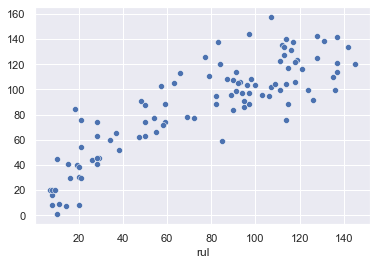

In [30]:
sns.scatterplot(y_test, y_hat_test)

# Review: our signals

In [31]:
# before we start plotting, lets implement the condition specific scaling
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['op1'] = df_op_cond['op1'].round()
    df_op_cond['op2'] = df_op_cond['op2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['op1'].astype(str) + '_' + \
                        df_op_cond['op2'].astype(str) + '_' + \
                        df_op_cond['op3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [32]:
X_train = DF_TRAIN.copy()
X_test = DF_TEST.copy()
X_test.rename(columns = {"remaining_rul": "rul"}, inplace=True)

X_train_condition = add_operating_condition(X_train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, FEATS)

In [88]:
def plot_signal(df, signal_name, id=None):
    plt.figure(figsize=(13,5))
    
    if id:
        plt.plot('rul', signal_name, 
                data=df[df['id']==id])
    else:
        for i in df['id'].unique():
            if (i % 10 == 0):  # only ploting every 10th id
                plt.plot('rul', signal_name, 
                         data=df[df['id']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

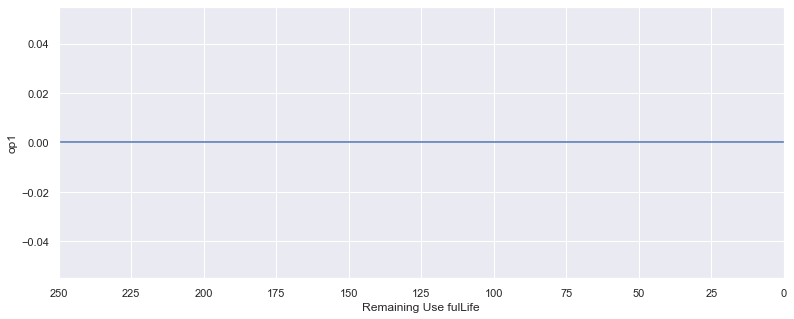

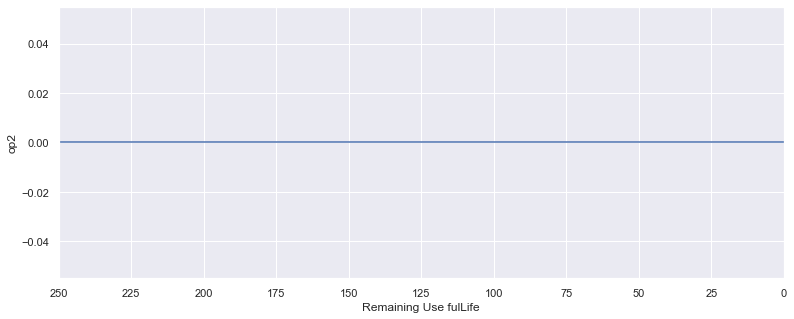

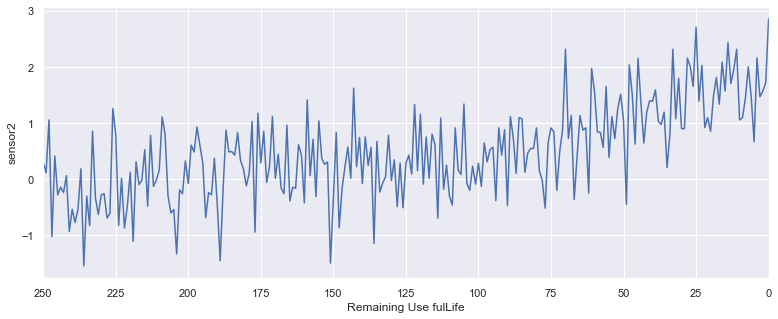

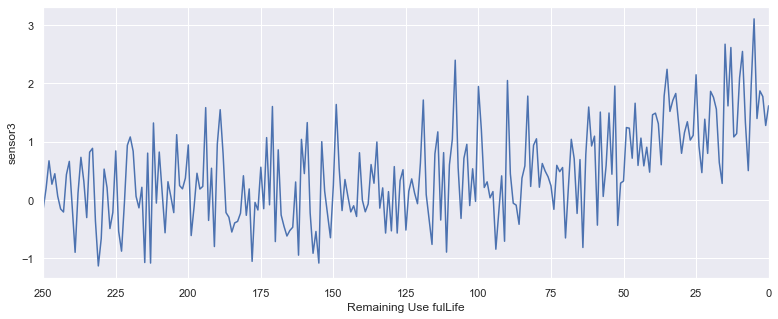

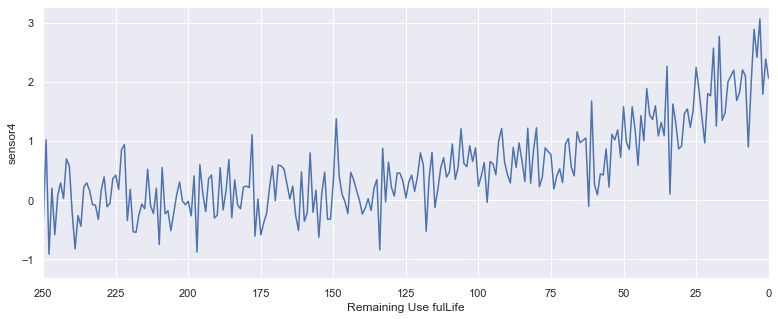

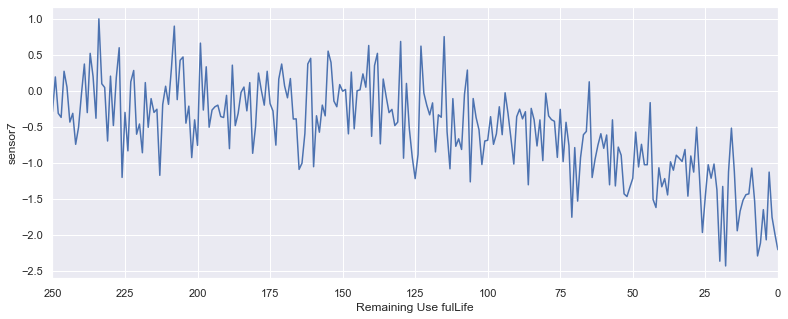

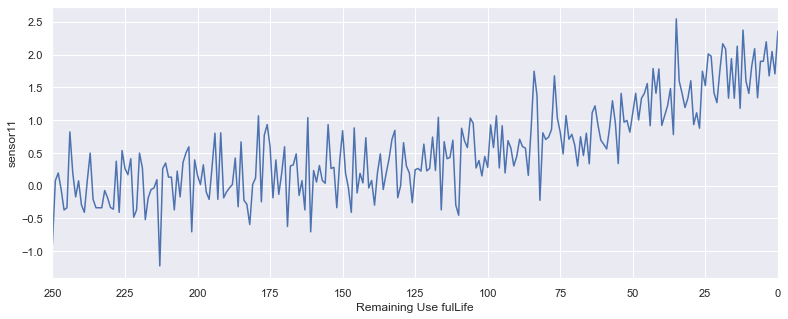

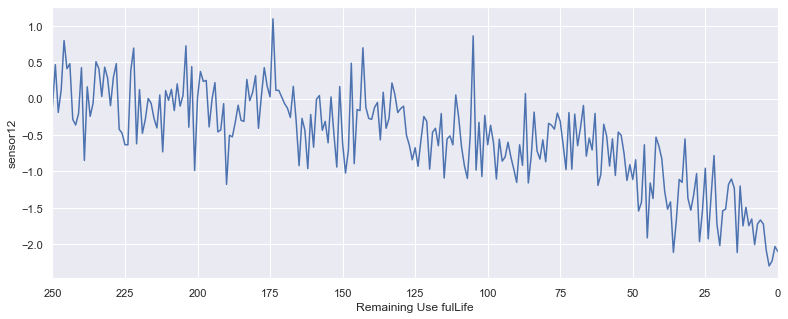

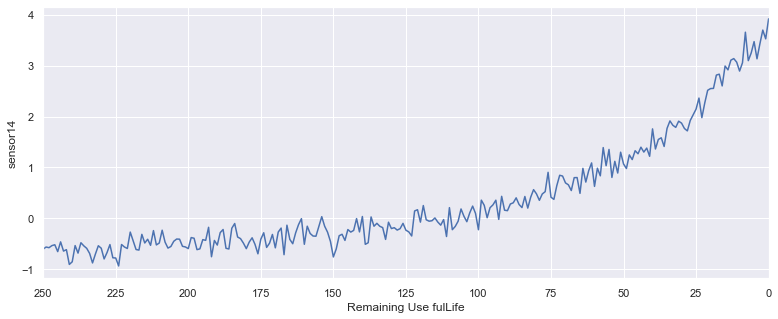

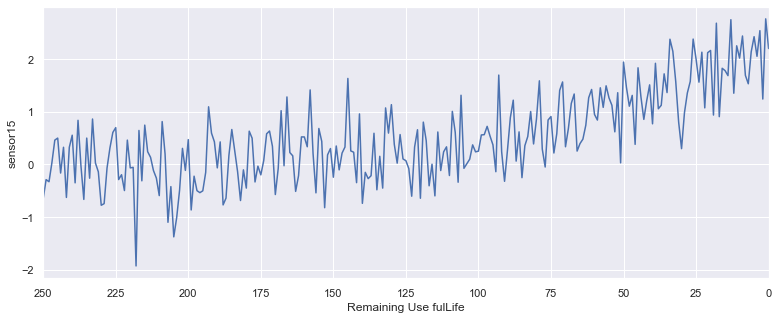

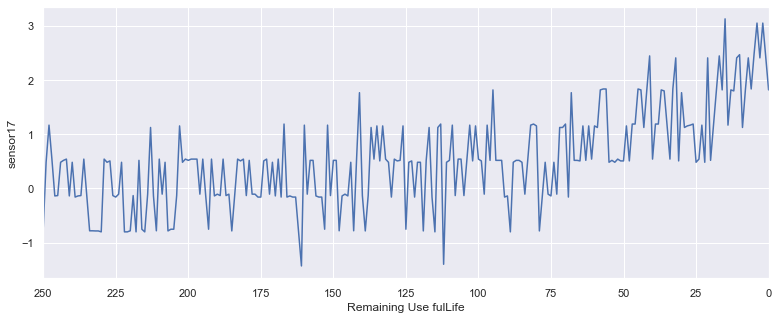

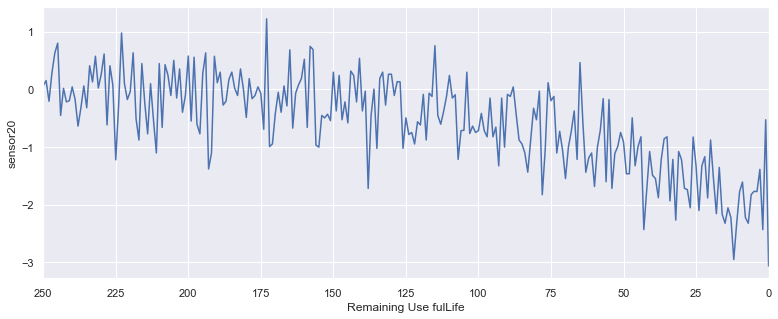

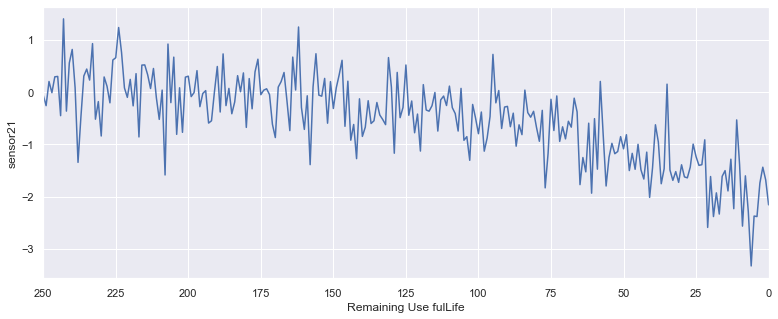

In [89]:
for sensor in FEATS:
    plot_signal(X_train_condition_scaled, sensor, id=56)

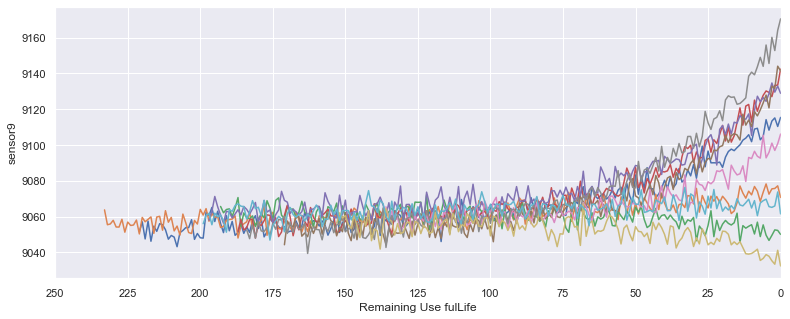

In [90]:
plot_signal(X_train_condition_scaled, signal_name="sensor9")

In [33]:
FEATS = ['op1',
  'op2',
  'sensor2',
  'sensor3',
  'sensor4',
  'sensor7',
  'sensor11',
  'sensor12',
  'sensor14',
  'sensor15',
  'sensor17',
  'sensor20',
  'sensor21']

allfeats =  [c for c in list(DF_TRAIN) if re.match("(op|sen)", c)]  
drop_sensors = [element for element in allfeats if element not in FEATS] 

In [ ]:

mask = df.groupby('id')['cycle'].transform(create_mask, samples=n_samples).astype(bool)
df = df[mask]

# LSTM data preparation
We can reuse some of the functions from last time, like exponential_smoothing and train_val_group_split

In [34]:
train = DF_TRAIN.copy()
sensors = [c for c in list(train) if re.match("sen", c)]  

In [35]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4 ):
    # ewm(span : not set. maybe set to 4)
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('id')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each id to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('id')['id'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [36]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed 
def train_val_group_split(X, y, gss, groups, print_groups=True): 
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['id'].unique())
            print('validate_split_engines', train.iloc[idx_val]['id'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

# Review: LSTM Sequence

In [102]:
d = {'id': [1]*5 + [2]*5,
     'X': [10., 10.2, 10.4, 10.6, 10.8, 20., 20.2, 20.4, 20.6, 20.8],
     'K': [10., 101.2, 102.4, 103.6, 104.8, 205., 205.2, 260.4, 270.6, 207.8],
     'y': [1.4, 1.4, 1.3, 1.2, 1.1, 12.4, 12.4, 22.3, 22.2, 32.1]}
example_df = pd.DataFrame(data=d)
example_df

,id,X,K,y
0,1,10.0,10.0,1.4
1,1,10.2,101.2,1.4
2,1,10.4,102.4,1.3
3,1,10.6,103.6,1.2
4,1,10.8,104.8,1.1
5,2,20.0,205.0,12.4
6,2,20.2,205.2,12.4
7,2,20.4,260.4,22.3
8,2,20.6,270.6,22.2
9,2,20.8,207.8,32.1


## Features

In [157]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

def gen_data_wrapper(df, sequence_length, columns, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    data_gen = (list(gen_train_data(df[df['id']==id], sequence_length, columns))
               for id in ids)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

## Labels

In [158]:
def gen_labels(df, sequence_length, label):
    # label = ['y']
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return  data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

## padding

In [159]:
# padding example
a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length

a 

array([[-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.]])

In [161]:
# padding example
a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
b = np.full(shape=(2,3), fill_value=0.)  # available sequence length

idx = a.shape[0] - b.shape[0]  # equals to 3

a[idx:,:] = b 
a

array([[-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.]])

# RUL LSTM

## model class

In [82]:
DF_TRAIN.values.shape

(20631, 28)

In [83]:
class BaseModelRUL():
    def __init__(self,data = pd.DataFrame(), test_data = pd.DataFrame, sequence_length = 6, \
                 n_samples=4, alpha=0.4, n_splits=1, train_size=0.80, label="rul", sensors=None,\
                 random_state=123, add_op=True, to_ewm=True, to_scale=True, to_clip=True, clipper_upper=150):
        self.sequence_length = sequence_length
        if data.empty:
            self.df_train = DF_TRAIN.copy()
        else:
            self.df_train = data.copy()
        
        if test_data.empty:
            self.df_test = DF_TEST.copy()
        else:
            self.df_test = test_data.copy()
            
        if not sensors:
            self.sensors = [c for c in list(self.df_train) if re.match("sen",c)]
        else:
            if isinstance(sensors, str):
                sensors = [sensors]
            self.sensors = sensors
        self.n_splits = n_splits
        self.n_samples = n_samples
        self.alpha = alpha 
        self.label = label
        self.random_state = random_state
        self.train_size = train_size
        self.add_op=add_op
        self.to_ewm=to_ewm
        self.to_scale=to_scale
        self.to_clip=to_clip
        self.clipper_upper=clipper_upper
        
        self.gss = GroupShuffleSplit(n_splits=self.n_splits, train_size=self.train_size, random_state=self.random_state)
        #n split = 1

              
    def add_operating_condition(self, df):
        df_op_cond = df.copy() 
        df_op_cond['op1'] = df_op_cond['op1'].round()
        df_op_cond['op2'] = df_op_cond['op2'].round(decimals=2)

        # converting settings to string and concatanating makes the operating condition into a categorical variable
        df_op_cond['op_cond'] = df_op_cond['op1'].astype(str) + '_' + \
                            df_op_cond['op2'].astype(str) + '_' + \
                            df_op_cond['op3'].astype(str)

        return df_op_cond

    def scaling(self):
        # apply operating condition specific scaling
        scaler = StandardScaler()
        
        if self.add_op:
            df_train = self.add_operating_condition(df = self.df_train)
            df_test = self.add_operating_condition(df = self.df_test) 
            for condition in df_train['op_cond'].unique():
                scaler.fit(df_train.loc[df_train['op_cond']==condition, self.sensors])
                df_train.loc[df_train['op_cond']==condition, self.sensors] = \
                    scaler.transform(df_train.loc[df_train['op_cond']==condition, self.sensors])
                df_test.loc[df_test['op_cond']==condition, self.sensors] = \
                    scaler.transform(df_test.loc[df_test['op_cond']==condition, self.sensors])
        else:
            df_train = self.df_train.copy()
            df_test = self.df_test.copy()
            scaler.fit(df_train[self.sensors])
            df_train[self.sensors] = scaler.transform(df_train[self.sensors])
            df_test[self.sensors] = scaler.transform(df_test[self.sensors])
             
        return df_train, df_test
    
    def create_mask(self, data, samples):
        #drop first n_samples of each id to reduce filter delay
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
        
    def ewm_data(self, df):
        # ewm(span : not set. maybe set to 4) 
        # n_samples: beginning n_samples rows for each engine id
        df_smoothen = df.copy()
        # first, take the exponential weighted mean
        df_smoothen[self.sensors] = df_smoothen.groupby('id')[self.sensors].apply(lambda x: x.ewm(alpha=self.alpha).mean())  

        mask = df_smoothen.groupby('id')['id'].transform(self.create_mask, samples=self.n_samples).astype(bool)
        df_smoothen = df_smoothen[mask] 
        return df_smoothen
 
    
    def gen_train_data(self, df=pd.DataFrame()): 
        data_ = df[self.sensors].values
        num_elements = data_.shape[0]

        # -1 and +1 because of Python indexing
        for start, stop in zip(range(0, num_elements-(self.sequence_length-1)), \
                               range(self.sequence_length, num_elements+1)):
            yield data_[start:stop, :]
    
    
    def gen_data_wrapper(self, df, ids): 
        data_gen = (list(self.gen_train_data(df[df['id']==id]))
                   for id in ids) 
        data_array = np.concatenate(list(data_gen)).astype(np.float32)
        
        return data_array       

    def gen_labels(self, df): 
        data_np = df[[self.label]].values
        num_elements = data_np.shape[0]

        # -1 because I want to predict the rul of that last row in the sequence, not the next row
        return  data_np[self.sequence_length-1:num_elements, :]  

    def gen_label_wrapper(self, df, ids): 
        label_gen = [self.gen_labels(df[df['id']==id]) 
                    for id in ids]
        label_array = np.concatenate(label_gen).astype(np.float32)
        return label_array
     
    def gen_test_data(self, df,  mask_value):
        if df.shape[0] < self.sequence_length:
            data_np = np.full(shape=(self.sequence_length, len(self.sensors)), fill_value=mask_value) # pad
            idx = data_np.shape[0] - df.shape[0]
            data_np[idx:,:] = df[self.sensors].values  # fill with available data
        else:
            data_np = df[self.sensors].values

        # specifically yield the last possible sequence
        stop = num_elements = data_np.shape[0]
        start = stop - self.sequence_length
        for i in list(range(1)):
            yield data_np[start:stop, :]   
            
    def generic_split(self, X, y, groups, print_groups=False): 
        # groups: groups=X_train_interim['id'].unique()
        # groups is ids
        for idx_train, idx_val in self.gss.split(X, y, groups=groups):
            if print_groups:
                print('train_split_engines', train.iloc[idx_train]['id'].unique())
                print('validate_split_engines', train.iloc[idx_val]['id'].unique(), '\n')

            X_train_split = X.iloc[idx_train].copy()
            y_train_split = y.iloc[idx_train].copy()
            X_val_split = X.iloc[idx_val].copy()
            y_val_split = y.iloc[idx_val].copy()
        return X_train_split, y_train_split, X_val_split, y_val_split
     
    def padding(self):
        ### information: how padding works
        # padding example
        a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
        b = np.full(shape=(2,3), fill_value=0.)  # available sequence length 
        idx = a.shape[0] - b.shape[0]  # equals to 3 
        a[idx:,:] = b 
  
    def prepare_data(self): 
        train, test = self.df_train, self.df_test
        
        if self.to_scale:
            train = self.add_operating_condition(train)
            test = self.add_operating_condition(test) 
        if self.to_ewm:
            train = self.ewm_data(train)
            test = self.ewm_data(test)
        
        if self.to_clip:
            train[self.label].clip(upper=125, inplace=True) 
          
        for train_unit, val_unit in self.gss.split(train['id'].unique(), groups=train['id'].unique()):
            train_unit = train['id'].unique()[train_unit]  # gss returns indexes and index starts at 1
            val_unit = train['id'].unique()[val_unit]

            train_split_array = self.gen_data_wrapper(train,   train_unit)
            train_split_label = self.gen_label_wrapper(train,  train_unit)

            val_split_array = self.gen_data_wrapper(train,  val_unit)
            val_split_label = self.gen_label_wrapper(train,   val_unit)
            
        return train_split_array, train_split_label, val_split_array, val_split_label

    def build_model(self):
        train_split_array, train_split_label, val_split_array, val_split_label = self.prepare_data()
        model = Sequential()
        model.add(Masking(mask_value=-99., input_shape=(self.sequence_length, train_split_array.shape[2])))
        model.add(LSTM(32, activation='tanh'))
        model.add(Dense(1)) 
    
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.save_weights('simple_lstm_weights.h5') 
    
        model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
        model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=5,
                           batch_size=32)
        return history, model 
        
    def plot_loss(self, fit_history):
        # plot history
        plt.figure(figsize=(13,5))
        plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
        plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
 
    def predict_evaluate(self):
        # predict and evaluate
        train_split_array, train_split_label, val_split_array, val_split_label = self.prepare_data()
        _, model = self.build_model()
        y_hat_train = model.predict(train_split_array)
        self.evaluate(train_split_label, y_hat_train, 'train')

        y_hat_test = model.predict(val_split_array)
        self.evaluate(val_split_label, y_hat_test)
        
    def evaluate(self, y_true, y_hat, label='test'):
        mse = mean_squared_error(y_true, y_hat)
        rmse = np.sqrt(mse)
        variance = r2_score(y_true, y_hat)
        print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [90]:
tmp = DF_TRAIN.copy()
gd = BaseModelRUL() 
results = gd.gen_train_data(tmp[tmp["id"]==43])
 

In [ ]:

def gen_train_data(self, df=pd.DataFrame()): 
    data_ = df[self.sensors].values
    num_elements = data_.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(self.sequence_length-1)), \
                           range(self.sequence_length, num_elements+1)):
        yield data_[start:stop, :]

### test it

Epoch 1/5
496/496 [==============================] - 8s 7ms/step - loss: 8541.6680 - val_loss: 8097.3745
Epoch 2/5
496/496 [==============================] - 2s 4ms/step - loss: 7952.1582 - val_loss: 7533.2153
Epoch 3/5
496/496 [==============================] - 2s 4ms/step - loss: 7398.2563 - val_loss: 7003.1680
Epoch 4/5
496/496 [==============================] - 2s 4ms/step - loss: 6877.8589 - val_loss: 6505.6260
Epoch 5/5
496/496 [==============================] - 2s 4ms/step - loss: 6389.0947 - val_loss: 6038.0254


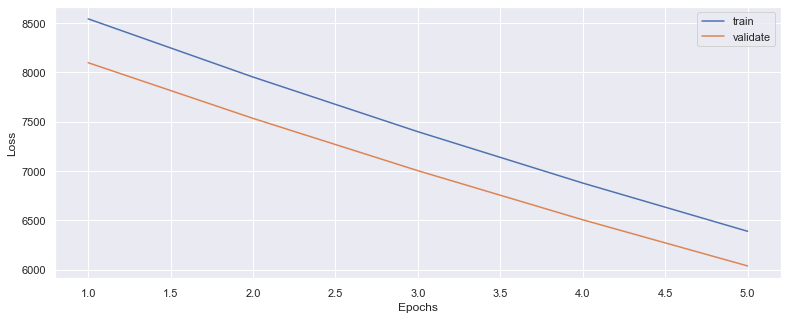

In [39]:
gd = BaseModelRUL() 
train_split_array, train_split_label, val_split_array, val_split_label = gd.prepare_data()
history, _ = gd.build_model() 
gd.plot_loss(history)

In [306]:
train_split_array.shape, train_split_label.shape, val_split_array.shape, val_split_label.shape

((15856, 6, 21), (15856, 1), (3875, 6, 21), (3875, 1))

In [301]:
train_split_array.shape, train_split_label.shape,  val_split_array.shape, val_split_label.shape

((15856, 6, 21), (15856, 1), (3875, 6, 21), (3875, 1))

In [ ]:
gd.predict_evaluate()

Epoch 1/5


In [176]:
train = DF_TRAIN.copy()
test = DF_TEST.copy()

drop_sensors = [c for c in list(DF_TRAIN) if ((c not in FEATS) and (  re.match('sen',c)))] 
remaining_sensors = [c for c in list(DF_TRAIN) if ((c   in FEATS) and (  re.match('sen',c)))]  

In [287]:
sequence_length = 20
train['rul'].clip(upper=125, inplace=True)
X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))
X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split


def sequential_split(X_train_interim, X_test_interim):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42) 
    for train_unit, val_unit in gss.split(X_train_interim['id'].unique(), groups=X_train_interim['id'].unique()):
        train_unit = X_train_interim['id'].unique()[train_unit]  # gss returns indexes and index starts at 1
        val_unit = X_train_interim['id'].unique()[val_unit]

        train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['rul'], train_unit)

        val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['rul'], val_unit) 
    return train_split_array, train_split_label, val_split_array, val_split_label
    
train_split_array, train_split_label, val_split_array, val_split_label = sequential_split(X_train_interim, X_test_interim)   

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['rul'])

In [288]:
test_gen = (list(gen_test_data(X_test_interim[X_test_interim['id']==id], sequence_length, remaining_sensors, -99.))
           for id in X_test_interim['id'].unique()) 
test_array = np.concatenate(list(test_gen)).astype(np.float32)

(18731, 20, 11)

In [289]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1)) 
    

In [290]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5') 

In [291]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=5,
                   batch_size=32)

Epoch 1/5
471/471 [==============================] - 12s 13ms/step - loss: 6319.3408 - val_loss: 4999.7061
Epoch 2/5
471/471 [==============================] - 5s 10ms/step - loss: 4305.7490 - val_loss: 3523.6702
Epoch 3/5
471/471 [==============================] - 5s 10ms/step - loss: 3036.6750 - val_loss: 2475.4541
Epoch 4/5
471/471 [==============================] - 5s 10ms/step - loss: 2130.9089 - val_loss: 1733.3010
Epoch 5/5
471/471 [==============================] - 5s 10ms/step - loss: 1479.6545 - val_loss: 1190.9915


In [293]:
 train_split_label.shape

(15041, 1)

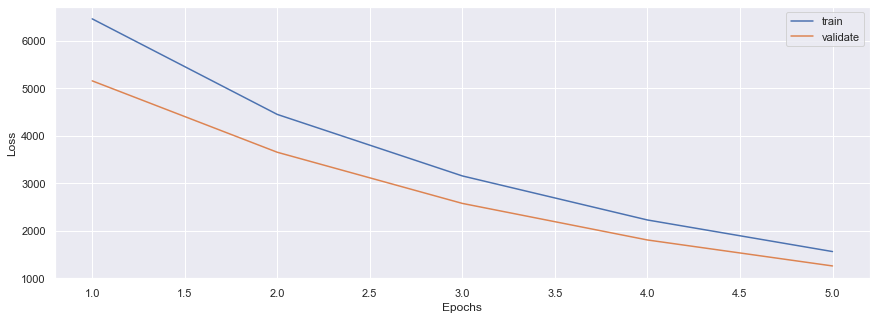

In [254]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [201]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

586/586 [==============================] - 4s 3ms/step
train set RMSE:35.80859375, R2:0.2676750210606912
4/4 [==============================] - 0s 4ms/step
test set RMSE:32.40287804825374, R2:0.3919943313554166


With an RMSE of 29.043 the current LSTM is already quite an improvement over the baseline model, about (34.594 - 29.043) / 34.594 * 100 = 16.04%  
There are two more things to check before hyperparameter tuning;  
    - (I) model performance without sensors 8, 9, 13 and 14 and  
    - (II) validation loss behavior when running more epochs

### try with less sensors

Epoch 1/5
496/496 [==============================] - 8s 8ms/step - loss: 8783.3145 - val_loss: 8360.9219
Epoch 2/5
496/496 [==============================] - 2s 4ms/step - loss: 8240.9863 - val_loss: 7839.8027
Epoch 3/5
496/496 [==============================] - 2s 4ms/step - loss: 7727.5435 - val_loss: 7346.3682
Epoch 4/5
496/496 [==============================] - 2s 4ms/step - loss: 7241.3745 - val_loss: 6879.4600
Epoch 5/5
496/496 [==============================] - 2s 4ms/step - loss: 6781.0571 - val_loss: 6437.0088


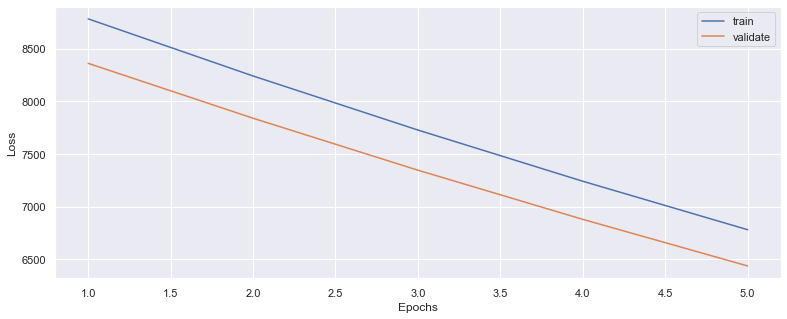

In [13]:
sensors = ['sensor2',
 'sensor3',
 'sensor4',
 'sensor7',
 'sensor11',
 'sensor12',
 'sensor14',
 'sensor15',
 'sensor17',
 'sensor20',
 'sensor21']
gd = GenerateData(sensors=sensors) 
train_split_array, train_split_label, val_split_array, val_split_label = gd.prepare_data()
history, _ = gd.build_model() 
gd.plot_loss(history)

In [14]:
gd.predict_evaluate()

Epoch 1/5
496/496 [==============================] - 8s 8ms/step - loss: 8647.2520 - val_loss: 8150.9448
Epoch 2/5
496/496 [==============================] - 2s 4ms/step - loss: 7960.0688 - val_loss: 7497.0146
Epoch 3/5
496/496 [==============================] - 2s 4ms/step - loss: 7321.3462 - val_loss: 6889.1099
Epoch 4/5
496/496 [==============================] - 2s 4ms/step - loss: 6727.6143 - val_loss: 6324.7119
Epoch 5/5
496/496 [==============================] - 2s 2ms/step
train set RMSE:76.89740753173828, R2:-2.387466131086143
122/122 [==============================] - 0s 2ms/step
test set RMSE:76.15988159179688, R2:-2.3163046442838326


##### the following are test code

In [202]:
X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['id'].unique(), groups=X_train_interim['id'].unique()):
    train_unit = X_train_interim['id'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['id'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['rul'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['rul'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['rul'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['id']==id], sequence_length, remaining_sensors, -99.))
           for id in X_test_interim['id'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

In [203]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

In [204]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('fewer_sensors_lstm_weights.h5')

In [205]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('fewer_sensors_lstm_weights.h5')

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=5,
                    batch_size=32)

Epoch 1/5
471/471 [==============================] - 11s 14ms/step - loss: 6497.3618 - val_loss: 5183.7886
Epoch 2/5
471/471 [==============================] - 5s 10ms/step - loss: 4490.7798 - val_loss: 3702.4497
Epoch 3/5
471/471 [==============================] - 5s 10ms/step - loss: 3210.0632 - val_loss: 2633.3625
Epoch 4/5
471/471 [==============================] - 5s 10ms/step - loss: 2282.8066 - val_loss: 1861.0090
Epoch 5/5
471/471 [==============================] - 5s 10ms/step - loss: 1605.8201 - val_loss: 1307.2892


In [ ]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

Validation loss has increased a bit, although it may be difficult to fully account this change to the removal of the sensors compared to the re-initialized model weights. To be sure we'll include both sets of sensors in the hyperparameter tuning approach.   
Like last time, let's train once with considerably increased epochs to view how the validation loss behaves

In [43]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('fewer_sensors_lstm_weights.h5')

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=20,
                   batch_size=32)

Train on 45513 samples, validate on 11005 samples
Epoch 1/20
45513/45513 [==============================] - 33s 718us/sample - loss: 5484.8303 - val_loss: 3071.4030
Epoch 2/20
45513/45513 [==============================] - 27s 587us/sample - loss: 1956.3160 - val_loss: 1121.2153
Epoch 3/20
45513/45513 [==============================] - 25s 546us/sample - loss: 712.3561 - val_loss: 555.8329
Epoch 4/20
45513/45513 [==============================] - 22s 487us/sample - loss: 356.6203 - val_loss: 435.9709
Epoch 5/20
45513/45513 [==============================] - 23s 509us/sample - loss: 275.6997 - val_loss: 397.6051
Epoch 6/20
45513/45513 [==============================] - 23s 512us/sample - loss: 257.4796 - val_loss: 393.8462
Epoch 7/20
45513/45513 [==============================] - 22s 484us/sample - loss: 248.7880 - val_loss: 371.6038
Epoch 8/20
45513/45513 [==============================] - 23s 501us/sample - loss: 242.7756 - val_loss: 368.9780
Epoch 9/20
45513/45513 [==================

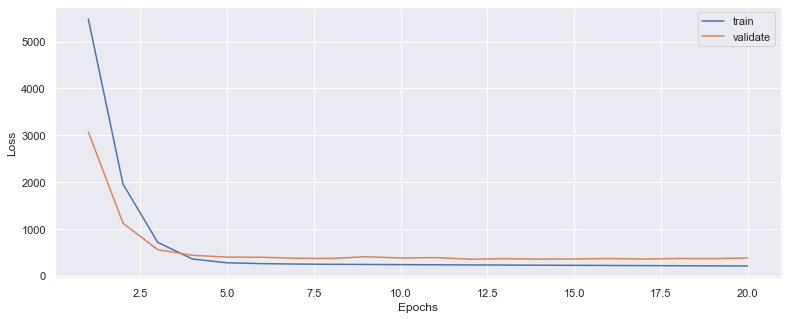

In [44]:
plot_loss(history)

In [45]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

train set RMSE:15.545417785644531, R2:0.857795579414809
test set RMSE:29.32099593032191, R2:0.7108086415870063


The validation loss seems quite stable, however the models starts to overfit slightly after 15 epochs. We can play around with different epochs, but shouldn't push it too far.

a


## Model 2
 
* parameters to tune: - alpha, filter strength - sequence_length - epochs - number of layers - nodes per layer - dropout - optimizer, learning rate (I choose to not tune this parameter) - activation function - batch size - included sensors## Tune hyperparameters
* parameters to tune: - alpha, filter strength - sequence_length - epochs - number of layers - nodes per layer - dropout - optimizer, learning rate (I choose to not tune this parameter) - activation function - batch size - included sensors

In [70]:
class RulLSTM():
    def __init__(self,data = pd.DataFrame(), test_data = pd.DataFrame, sequence_length = 6, \
                 n_samples=4, alpha=0.4, n_splits=1, train_size=0.80, label="rul", sensors=None,\
                 random_state=123, add_op=True, to_ewm=True, to_scale=True, \
                 to_clip=True, clipper_upper=150, best_model_file_prefix = None):
        
        self.sequence_length = sequence_length
        if data.empty:
            self.df_train = DF_TRAIN.copy()
        else:
            self.df_train = data.copy()
        
        if test_data.empty:
            self.df_test = DF_TEST.copy()
        else:
            self.df_test = test_data.copy()
            
        if not sensors:
            self.sensors = [c for c in list(self.df_train) if re.match("sen",c)]
        else:
            if isinstance(sensors, str):
                sensors = [sensors]
            self.sensors = sensors
        self.n_splits = n_splits
        self.n_samples = n_samples
        self.alpha = alpha 
        self.label = label
        self.random_state = random_state
        self.train_size = train_size
        self.add_op=add_op
        self.to_ewm=to_ewm
        self.to_scale=to_scale
        self.to_clip=to_clip
        self.clipper_upper=clipper_upper
        
        self.gss = GroupShuffleSplit(n_splits=self.n_splits, train_size=self.train_size, random_state=self.random_state)
        if not best_model_file_prefix:
            best_model_file_prefix = "rul_lstm_n"
        self.best_model_file_prefix = best_model_file_prefix
        #n split = 1

              
    def add_operating_condition(self, df):
        df_op_cond = df.copy() 
        df_op_cond['op1'] = df_op_cond['op1'].round()
        df_op_cond['op2'] = df_op_cond['op2'].round(decimals=2)

        # converting settings to string and concatanating makes the operating condition into a categorical variable
        df_op_cond['op_cond'] = df_op_cond['op1'].astype(str) + '_' + \
                            df_op_cond['op2'].astype(str) + '_' + \
                            df_op_cond['op3'].astype(str)

        return df_op_cond

    def scaling(self, df_train=pd.DataFrame(), df_test=pd.DataFrame(), sensors=None, add_op = True):
        # apply operating condition specific scaling
        
        if df_train.empty:
            df_train = self.df_train.copy()
        if df_test.empty:
            df_test = self.df_test.copy()
        
        if not sensors:
            sensors = self.sensors
            
        scaler = StandardScaler()
         
        if add_op:
            df_train = self.add_operating_condition(df = df_train)
            df_test = self.add_operating_condition(df = df_test) 
            for condition in df_train['op_cond'].unique():
                scaler.fit(df_train.loc[df_train['op_cond']==condition, sensors])
                df_train.loc[df_train['op_cond']==condition, sensors] = \
                    scaler.transform(df_train.loc[df_train['op_cond']==condition, sensors])
                df_test.loc[df_test['op_cond']==condition, sensors] = \
                    scaler.transform(df_test.loc[df_test['op_cond']==condition, sensors])
        else: 
            scaler.fit(df_train[sensors])
            df_train[sensors] = scaler.transform(df_train[sensors])
            df_test[sensors] = scaler.transform(df_test[sensors])
             
        return df_train, df_test
    
    def create_mask(self, data, samples):
        #drop first n_samples of each id to reduce filter delay
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
        
    def ewm_data(self, df, sensors=None, n_samples=None, alpha=None ):
        # ewm(span : not set. maybe set to 4) 
        # n_samples: beginning n_samples rows for each engine id
        if not sensors:
            sensors = self.sensors
        if not n_samples:
            n_samples = self.n_samples
        if not alpha:
            alpha = self.alpha
            
        df_smoothen = df.copy()
        # first, take the exponential weighted mean
        df_smoothen[sensors] = df_smoothen.groupby('id')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())  

        mask = df_smoothen.groupby('id')['id'].transform(self.create_mask, samples=n_samples).astype(bool)
        df_smoothen = df_smoothen[mask] 
        return df_smoothen 
    
  
 
    
    def gen_train_data(self, df, sensors, sequence_length): 
        data_ = df[sensors].values
        num_elements = data_.shape[0]

        # -1 and +1 because of Python indexing
        for start, stop in zip(range(0, num_elements-(sequence_length-1)), \
                               range(sequence_length, num_elements+1)):
            yield data_[start:stop, :]
    
    
    def gen_data_wrapper(self, df, sequence_length=None, sensors=None, ids=None):  
        if not sequence_length:
            sequence_length = self.sequence_length
        if not sensors:
            sensors = self.sensors
            
        data_gen = (list(self.gen_train_data(df[df['id']==id], sensors, sequence_length))
                   for id in ids) 
        data_array = np.concatenate(list(data_gen)).astype(np.float32)
        
        return data_array       

      
    
    def gen_labels(self, df,sequence_length, label): 
        #data_np = df[[self.label]].values
        data_np = df[label].values
        num_elements = data_np.shape[0]

        # -1 because I want to predict the rul of that last row in the sequence, not the next row
        return  data_np[sequence_length-1:num_elements, :]  

    def gen_label_wrapper(self, df, sequence_length=None, label=None, ids=None): 
        if not sequence_length:
            sequence_length = self.sequence_length
        if not label:
            label = self.label
        if isinstance(label, str):
            label = [label]
        
    
        label_gen = [self.gen_labels(df[df['id']==id], sequence_length, label) 
                    for id in ids]
        label_array = np.concatenate(label_gen).astype(np.float32)
        return label_array
     
    
     
    def gen_test_data(self, df,  mask_value):
        if df.shape[0] < self.sequence_length:
            data_np = np.full(shape=(self.sequence_length, len(self.sensors)), fill_value=mask_value) # pad
            idx = data_np.shape[0] - df.shape[0]
            data_np[idx:,:] = df[self.sensors].values  # fill with available data
        else:
            data_np = df[self.sensors].values

        # specifically yield the last possible sequence
        stop = num_elements = data_np.shape[0]
        start = stop - self.sequence_length
        for i in list(range(1)):
            yield data_np[start:stop, :]   
            
    def generic_split(self, X, y, groups, print_groups=False): 
        # groups: groups=X_train_interim['id'].unique()
        # groups is ids
        for idx_train, idx_val in self.gss.split(X, y, groups=groups):
            if print_groups:
                print('train_split_engines', train.iloc[idx_train]['id'].unique())
                print('validate_split_engines', train.iloc[idx_val]['id'].unique(), '\n')

            X_train_split = X.iloc[idx_train].copy()
            y_train_split = y.iloc[idx_train].copy()
            X_val_split = X.iloc[idx_val].copy()
            y_val_split = y.iloc[idx_val].copy()
        return X_train_split, y_train_split, X_val_split, y_val_split
     
    def padding(self):
        ### information: how padding works
        # padding example
        a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
        b = np.full(shape=(2,3), fill_value=0.)  # available sequence length 
        idx = a.shape[0] - b.shape[0]  # equals to 3 
        a[idx:,:] = b 
 

    def prepare_data(self): 
        train, test = self.df_train, self.df_test
        
        if self.to_scale:
            train = self.add_operating_condition(train)
            test = self.add_operating_condition(test) 
        if self.to_ewm:
            train = self.ewm_data(train)
            test = self.ewm_data(test)
        
        if self.to_clip:
            train[self.label].clip(upper=125, inplace=True) 
          
        for train_unit, val_unit in self.gss.split(train['id'].unique(), groups=train['id'].unique()):
            train_unit = train['id'].unique()[train_unit]  # gss returns indexes and index starts at 1
            val_unit = train['id'].unique()[val_unit] 
            
            train_split_array = self.gen_data_wrapper(train, None, None, train_unit)
            train_split_label = self.gen_label_wrapper(train, None, None, train_unit)

            val_split_array = self.gen_data_wrapper(train,None, None,  val_unit)
            val_split_label = self.gen_label_wrapper(train,  None, None, val_unit)
            
        return train_split_array, train_split_label, val_split_array, val_split_label

    def build_model(self):
        train_split_array, train_split_label, val_split_array, val_split_label = self.prepare_data()
        model = Sequential()
        model.add(Masking(mask_value=-99., input_shape=(self.sequence_length, train_split_array.shape[2])))
        model.add(LSTM(32, activation='tanh'))
        model.add(Dense(1)) 
    
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.save_weights('simple_lstm_weights.h5') 
    
        model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
        model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=5,
                           batch_size=32)
        return history, model 
        
    def plot_loss(self, fit_history):
        # plot history
        plt.figure(figsize=(13,5))
        plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
        plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
 
    def predict_evaluate(self, model_file = None):
        # predict and evaluate  
        train_split_array, train_split_label, val_split_array, val_split_label = self.prepare_data()
    
        if not model_file:
            _, model = self.build_model()
        else:
            model = load_model(model_file)
            
        y_hat_train = model.predict(train_split_array)
        self.evaluate(train_split_label, y_hat_train, 'train')

        y_hat_test = model.predict(val_split_array)
        self.evaluate(val_split_label, y_hat_test)
        
    def evaluate(self, y_true, y_hat, label='test'):
        mse = mean_squared_error(y_true, y_hat)
        rmse = np.sqrt(mse)
        variance = r2_score(y_true, y_hat)
        print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
        
        
    def predict(self, prod_data, model_file = None): 
        if not model_file:
            _, model = self.build_model()
        else:
            model = load_model(model_file) 
        
        if self.to_scale:
            prod_data = self.add_operating_condition(prod_data) 
        if self.to_ewm:
            prod_data = self.ewm_data(prod_data) 
             
        prod_data_gen = (list(self.gen_test_data(prod_data[prod_data['id']==id], self.sequence_length, self.sensors, -99.))
                   for id in prod_data['id'].unique())
        prod_array = np.concatenate(list(prod_data_gen)).astype(np.float32) 
        
        results = final_model.predict(prod_array)
        
        return results
    
    
    # input_shape = (sequence_length, train_array.shape[2])
    def build_model_full(self, input_shape, nodes_per_layer, dropout, activation, weights_file):
        model = Sequential()
        model.add(Masking(mask_value=-99., input_shape=input_shape))
        if len(nodes_per_layer) <= 1:
            model.add(LSTM(nodes_per_layer[0], activation=activation))
            model.add(Dropout(dropout))
        else:
            model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
            model.add(Dropout(dropout))
            model.add(LSTM(nodes_per_layer[1], activation=activation))
            model.add(Dropout(dropout))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')
        model.save_weights(weights_file)
        
        return model
    
    def prep_data(self, train, test, drop_sensors, remaining_sensors, alpha):
        X_train_interim = self.add_operating_condition(train.drop(drop_sensors, axis=1))
        X_test_interim = self.add_operating_condition(test.drop(drop_sensors, axis=1))

        
        #scaling(self, df_train=pd.DataFrame(), df_test=pd.DataFrame(), sensors=None, add_op = True)         
        X_train_interim, X_test_interim = self.scaling(X_train_interim, X_test_interim, remaining_sensors, add_op=False)
        
        # ewm_data(self, df, sensors=None, n_samples=None, alpha=None )
        X_train_interim = self.ewm_data(X_train_interim, remaining_sensors, 0, alpha)
        X_test_interim = self.ewm_data(X_test_interim, remaining_sensors, 0, alpha)

        return X_train_interim, X_test_interim    

    def search_params(self, interations = 10):
        results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
                                        'epochs', 'nodes', 'dropout', 
                                        'activation', 'batch_size', 
                                        'sequence_length', 'sensor_length'])  

        weights_file = f'{current_path}/lstm_hyper_parameter_weights.h5'

        alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

        sequence_list = list(np.arange(10,40+1,5))
        epoch_list = list(np.arange(5,20+1,5))
        nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

        # lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
        dropouts = list(np.arange(1,5)/10)  

        # again, earlier testing revealed relu performed significantly worse, so I removed it from the options
        activation_functions = ['tanh', 'sigmoid']
        batch_size_list = [32, 64, 128, 256]
        sensor_list = [[c for c in list(DF_TRAIN) if re.match("sen",c)]] 
        sensor_names = [c for c in list(DF_TRAIN) if re.match("sen",c)]
        tuning_options = np.prod([len(alpha_list),
                                  len(sequence_list),
                                  len(epoch_list),
                                  len(nodes_list),
                                  len(dropouts),
                                  len(activation_functions),
                                  len(batch_size_list),
                                  len(sensor_list)])

         
        mse = []
        best_mse = np.inf
        best_two = {"first": {"mse": np.inf, "model": 0}, "second": {"mse": np.inf, "model": 0} }
        
        for i in range(interations):
            if interations < 10:
                print('iteration ', i+1)
            elif ((i+1) % 10 == 0):
                print('iteration ', i+1)
 
            # init parameters
            alpha = random.sample(alpha_list, 1)[0]
            sequence_length = random.sample(sequence_list, 1)[0]
            epochs = random.sample(epoch_list, 1)[0]
            nodes_per_layer = random.sample(nodes_list, 1)[0]
            dropout = random.sample(dropouts, 1)[0]
            activation = random.sample(activation_functions, 1)[0]
            batch_size = random.sample(batch_size_list, 1)[0]
            remaining_sensors = random.sample(sensor_names, 1)[0]
            remaining_sensors = [remaining_sensors]
            drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

            # create model
            input_shape = (sequence_length, len(remaining_sensors))
            
            # return input_shape, nodes_per_layer, dropout, activation, weights_file
        
            model = self.build_model_full(input_shape, nodes_per_layer, dropout, activation, weights_file)
            # create train-val split
            X_train_interim, X_test_interim = self.prep_data(train, test, drop_sensors, remaining_sensors, alpha)            
            gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
            
            for train_unit, val_unit in gss.split(X_train_interim['id'].unique(), groups=X_train_interim['id'].unique()):
                train_unit = X_train_interim['id'].unique()[train_unit]  # gss returns indexes and index starts at 1
                train_split_array = self.gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
                #train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['rul'], train_unit)
                train_split_label = self.gen_label_wrapper(X_train_interim, sequence_length, 'rul', train_unit)

                val_unit = X_train_interim['id'].unique()[val_unit]
                val_split_array = self.gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
                #val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['rul'], val_unit)
                val_split_label = self.gen_label_wrapper(X_train_interim, sequence_length, 'rul', val_unit)

                # train and evaluate model
                model.compile(loss='mean_squared_error', optimizer='adam')
                model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

                history = model.fit(train_split_array, train_split_label,
                                    validation_data=(val_split_array, val_split_label),
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    verbose=0)
                mse_ = history.history['val_loss'][-1]
                mse.append(mse_)
                #mse.append(history.history['val_loss'][-1])  
                if mse_ < best_two["second"]["mse"]:
                    if mse_ > best_two["first"]["mse"]:
                        best_two["second"]["mse"] = mse_
                        best_two["second"]["model"] = model
                        best_two["second"]["history"] = history
                    else: 
                        best_two["second"]["mse"] =  best_two["first"]["mse"]
                        best_two["second"]["model"] = best_two["first"]["model"] 
                        best_two["second"]["history"] = history
                        
                        best_two["first"]["mse"] = mse_
                        best_two["first"]["model"] = model
                        best_two["first"]["history"] = history
                           
            # append results
            result = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
                 'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
                 'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
                 'sensor_length':len(remaining_sensors)}
            results = results.append(pd.DataFrame(result, index=[0]), ignore_index=True)
            break
        if not os.path.exists(os.getcwd()+"/results"):
            os.mkdir(os.getcwd()+"/results")
            
        result_file = os.getcwd()+"/results/nn_lstm_results.csv"
        arch_history = os.getcwd()+"/results/nn_lstm_history"
        
        results.to_csv(result_file, index=False) 
        for k,v in best_two.items():
            model_file = os.getcwd()+f"/results/{self.best_model_file_prefix}_{k}.h5"
            v["model"].save(model_file) 
            with open(f'{arch_history}_{k}', 'wb') as file_pi:
                pickle.dump(history.history, file_pi)
 
        return best_two


In [71]:
lstm = RulLSTM()
best_two = lstm.search_params(interations=2) 

iteration  1


NameError: name 'pickle' is not defined

In [67]:

if not os.path.exists(os.getcwd()+"/results"):
    os.mkdir(os.getcwd()+"/results")


In [ ]:
# predict and evaluate
y_hat_train = final_model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = final_model.predict(test_array)
evaluate(y_test, y_hat_test)

## Results

In [50]:
# predict and evaluate
y_hat_train = final_model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = final_model.predict(test_array)
evaluate(y_test, y_hat_test)

train set RMSE:12.35975170135498, R2:0.9112171726749143
test set RMSE:25.35340838205415, R2:0.7837776516770107
